In [ ]:
!pip install sklearn

In [ ]:
%matplotlib inline

In [ ]:
!pip install tensorflow


# Recognizing hand-written digits

This example shows how scikit-learn can be used to recognize images of
hand-written digits, from 0-9.


In [ ]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pickle
from ctypes import *
from numpy.ctypeslib import ndpointer
import tensorflow as tf
from qmcpy import *

m = 10
nu = 3

Ndata = 60000
Nqmc = 2**m;

# load mnist data and rescale to 10x10
mnist = tf.keras.datasets.mnist

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [ ]:
train_labels


* What was discussed0
    * Figured out how they propose to change the RMSE to change the data computations
    * Actually computes the neural network in C….
    * Steps to compile and reproduce Examples 1 and 2 in QMCPy’s ml_train_and_compress branch (SC’s request)
* Next meeting: 10am Oct 15, Sat


In [ ]:
len(train_labels)

In [12]:
import numpy as np
import pickle
from ctypes import *
from numpy.ctypeslib import ndpointer
import tensorflow as tf
from qmcpy import *
import  os
libpath = os.path.join('..', 'qmcpy','machine_learning','compression', 'c_lib','c_lib.cpython-39-darwin.so' )
sequencepath = os.path.join('..','qmcpy','machine_learning','compression', 'sobol.dat' )
sequencepath = os.path.relpath(libpath, start = os.curdir)
libpath = os.path.relpath(sequencepath, start = os.curdir)
m = 10
nu = 3

Ndata = 60000
Nqmc = 2**m;

# load mnist data and rescale to 10x10
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train =  np.float64(tf.one_hot(y_train,10).numpy())


x_train= x_train[:Ndata,:,:]
y_train = y_train[:Ndata]

x_train = x_train[...,tf.newaxis]
x_train = tf.image.resize(x_train,[10,10])
x_train = x_train.numpy()[:,:,:,0]


# data dimension
Ndata=x_train.shape[0]
s=x_train.shape[1]*x_train.shape[2]
outs = y_train.shape[1]

# flatten 10x10 to 100x1 for weight computation
x_train_flat = np.float64(0.99*np.transpose(x_train.reshape(x_train.shape[0],s)))

# load qmc points
#dig_net = DigitalNetB2(2,seed=6)
#qmc_points_gen = np.array(dig_net.gen_samples(Nqmc), dtype=np.ndarray)
qmc_points = np.loadtxt('/Users/r2q2/Projects/QMCSoftware/qmcpy/machine_learning/compression/sobol.dat')
#breakpoint()
qmc_points = qmc_points[0:Nqmc,0:s]


print(qmc_points.shape)
print(x_train_flat.shape)
print(y_train.shape)
# load c functions 
lib = cdll.LoadLibrary('/Users/r2q2/Projects/QMCSoftware/qmcpy/machine_learning/c_lib/c_lib.cpython-39-darwin.so')
computeWeights = lib.computeWeights
computeWeights.restype=ndpointer(dtype=c_double,shape=(1+outs,Nqmc))
print('Weights loaded')

# compute weights
weights = computeWeights(c_int(nu),
                         c_int(m),
                         c_int(s),
                         c_int(Ndata),
                         c_int(Nqmc),
                         c_int(outs),
                         c_void_p(x_train_flat.ctypes.data),
                         c_void_p(qmc_points.ctypes.data),c_void_p(y_train.ctypes.data))
weights = np.transpose(weights)

#breakpoint()
print(weights.shape)
with open('weights.pkl', 'wb') as handle:
    pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


(1024, 100)
(100, 60000)
(60000, 10)
Weights loaded
(1024, 11)


In [48]:
weights[1]

array([5.15690104e-04, 4.71354167e-05, 6.29557292e-05, 6.09375000e-05,
       4.71679687e-05, 5.30273438e-05, 5.13346354e-05, 4.57031250e-05,
       4.78515625e-05, 5.50455729e-05, 4.45312500e-05])

(1024, 100)

(100, 60000)

Weights loaded

(1024, 11)

    array([[ 4.24768229e-02,  4.19723307e-03,  4.81731771e-03, ...,
         4.45003255e-03,  4.14186198e-03,  4.16787109e-03],
       [ 5.15690104e-04,  4.71354167e-05,  6.29557292e-05, ...,
         4.78515625e-05,  5.50455729e-05,  4.45312500e-05],
       [-5.51979167e-03, -5.43587240e-04, -6.30794271e-04, ...,
        -5.81933594e-04, -5.44856771e-04, -5.38509115e-04],
       ...,
       [ 1.36093750e-03,  1.37955729e-04,  1.52929688e-04, ...,
         1.41731771e-04,  1.38313802e-04,  1.35872396e-04],
       [-2.21803385e-03, -2.18326823e-04, -2.69856771e-04, ...,
        -2.38769531e-04, -2.12695312e-04, -2.16894531e-04],
       [ 2.44114583e-03,  2.51106771e-04,  2.73437500e-04, ...,
         2.50716146e-04,  2.41634115e-04,  2.43229167e-04]])
         
he is selecting the important column. Originally had 100 columns to 11 columns and proves that the accuracy is still good

To reproduce make two deep learning algorithms

In [20]:
print(y_train.shape)

(60000, 10)


In [22]:
print(x_train_flat.shape)

(100, 60000)


In [24]:
x_train_flat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


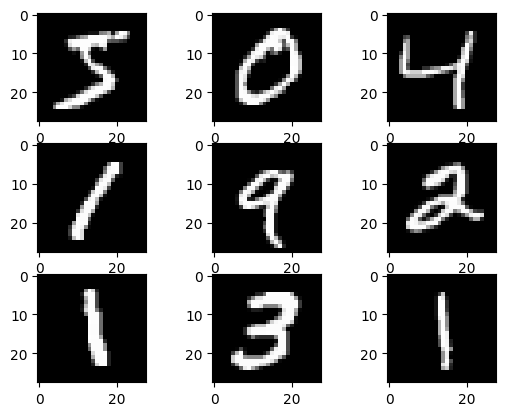

In [34]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [35]:

# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

NameError: name 'valX' is not defined

In [36]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

NameError: name 'to_categorical' is not defined

In [37]:

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [38]:
# convert from integers to floats
train_norm = train.astype('float32')
test_norm = test.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

NameError: name 'train' is not defined

In [39]:

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [40]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [41]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [42]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [43]:
#summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

In [44]:

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

> 98.492
> 98.642
> 98.633
> 98.792
> 98.817


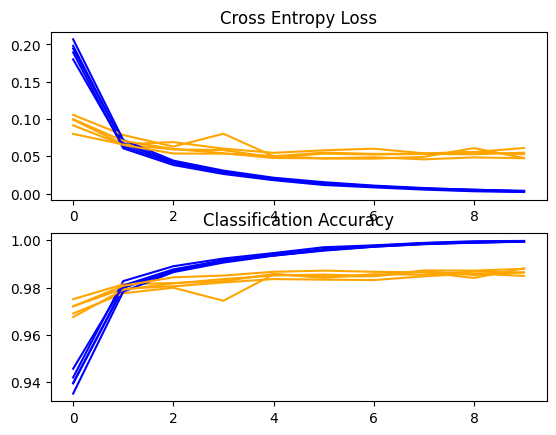

Accuracy: mean=98.675 std=0.118, n=5


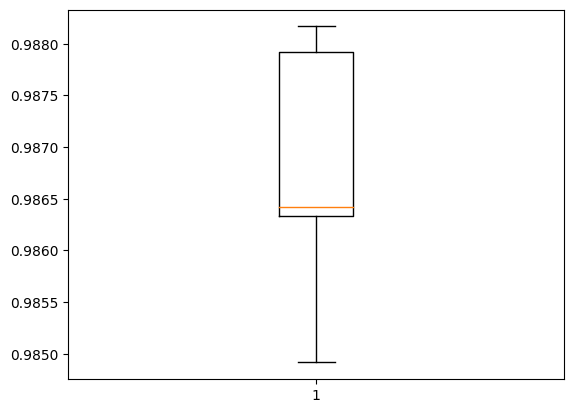

In [47]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

In [1]:
import  os
libpath = os.path.join('..', 'qmcpy','machine_learning','compression', 'c_lib','c_lib.cpython-39-darwin.so' )
sequencepath = os.path.join('..','qmcpy','machine_learning','compression', 'sobol.dat' )
sequencepath = os.path.relpath(libpath, start = os.curdir)
libpath = os.path.relpath(sequencepath, start = os.curdir)

In [46]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Using cached scikit_learn-1.1.2-cp39-cp39-macosx_12_0_arm64.whl (7.7 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1304 sha256=8c19bffeb9024770191f1560380350ca76cb0e10c9aeb01a2cc01c6fa91bf568
  Stored in directory: /Users/r2q2/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [21]:
import os
#/machine_learning/compression/c_lib/computeMXY.so
path = os.path.join('..','qmcpy','machine_learning','compression', 'c_lib','computeMXY.so' )
path

'../qmcpy/machine_learning/compression/c_lib/computeMXY.so'

In [30]:
path = os.path.join('..','qmcpy','machine_learning','compression', 'c_lib','computeMXY.so' )
os.path.relpath(path, start = os.curdir)

'../qmcpy/machine_learning/compression/c_lib/computeMXY.so'

## Digits dataset

The digits dataset consists of 8x8
pixel images of digits. The ``images`` attribute of the dataset stores
8x8 arrays of grayscale values for each image. We will use these arrays to
visualize the first 4 images. The ``target`` attribute of the dataset stores
the digit each image represents and this is included in the title of the 4
plots below.

Note: if we were working from image files (e.g., 'png' files), we would load
them using :func:`matplotlib.pyplot.imread`.



In [ ]:
x_train[0]

In [ ]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
digits[0]

## Classification

To apply a classifier on this data, we need to flatten the images, turning
each 2-D array of grayscale values from shape ``(8, 8)`` into shape
``(64,)``. Subsequently, the entire dataset will be of shape
``(n_samples, n_features)``, where ``n_samples`` is the number of images and
``n_features`` is the total number of pixels in each image.

We can then split the data into train and test subsets and fit a support
vector classifier on the train samples. The fitted classifier can
subsequently be used to predict the value of the digit for the samples
in the test subset.



In [ ]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

Below we visualize the first 4 test samples and show their predicted
digit value in the title.



In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

:func:`~sklearn.metrics.classification_report` builds a text report showing
the main classification metrics.



In [ ]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

We can also plot a `confusion matrix <confusion_matrix>` of the
true digit values and the predicted digit values.



In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()